# Correlation and Diversification #

### Benefits of Diversification ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optiminization
from scipy.optimize import minimize

# Pretty Notation
from IPython.display import display, Math

In [3]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"Open",
        "High Price":"High",
        "Low Price":"Low",
        "Close Price":"Close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2023-01-01":]

In [5]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

In [7]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['Close']
df_data['AMZN'] = df_2['Close']
df_data['META'] = df_3['Close']
df_data['MSFT'] = df_4['Close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1).dropna()

df_returns

,AAPL,AMZN,META,MSFT
Date,,,,
2023-01-04,0.010314,-0.007924,0.021084,-0.043743
2023-01-05,-0.010605,-0.023726,-0.003376,-0.029638
2023-01-06,0.036794,0.035611,0.024263,0.011785
2023-01-09,0.004089,0.014870,-0.004230,0.009736
2023-01-10,0.004456,0.028732,0.027188,0.007617
...,...,...,...,...
2024-10-15,0.011025,0.000800,-0.007029,-0.000954
2024-10-16,-0.008852,-0.004262,-0.016170,-0.006257
2024-10-17,0.001596,0.003424,0.000243,0.001442


In [15]:
# Theoretically we could use the average as the expected returns (these are daily returns)

expected_returns = df_returns.mean() * 252

expected_returns

AAPL    0.379080
AMZN    0.487166
META    0.926389
MSFT    0.337040
dtype: float64

In [17]:
# The volatility is calculated with the standard deviations (also daily volatilities)

volat = df_returns.dropna().std() * np.sqrt(252)

volat

AAPL    0.218327
AMZN    0.305291
META    0.391234
MSFT    0.226368
dtype: float64

In [19]:
# Covariance Matrix

cov_matrix = df_returns.dropna().cov() * 252

cov_matrix

,AAPL,AMZN,META,MSFT
AAPL,0.047667,0.026083,0.031836,0.024854
AMZN,0.026083,0.093203,0.069223,0.042016
META,0.031836,0.069223,0.153064,0.048074
MSFT,0.024854,0.042016,0.048074,0.051242


In [25]:
# Create the Equal Weighted Portfolio

n_assets = 4
weights = np.array([1/n_assets] * n_assets)  # Equal weights

weights

array([0.25, 0.25, 0.25, 0.25])

In [31]:
# Portfolio expected return
portfolio_return = np.dot(weights, expected_returns)

# Portfolio variance and volatility
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility = np.sqrt(portfolio_variance)

print("\nPortfolio Expected Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)


Portfolio Expected Return: 0.5324188544288896
Portfolio Volatility: 0.22767121916371957


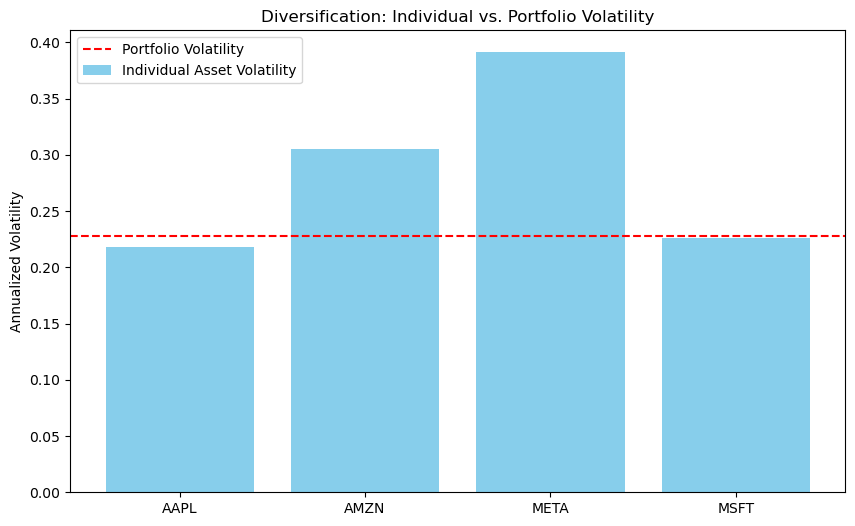

In [37]:
# Plot the Volatilities

plt.figure(figsize=(10, 6))
plt.bar(df_data.columns, volat, color='skyblue', label='Individual Asset Volatility')
plt.axhline(y=portfolio_volatility, color='red', linestyle='--', label='Portfolio Volatility')
plt.ylabel('Annualized Volatility')
plt.title('Diversification: Individual vs. Portfolio Volatility')
plt.legend()
plt.show()

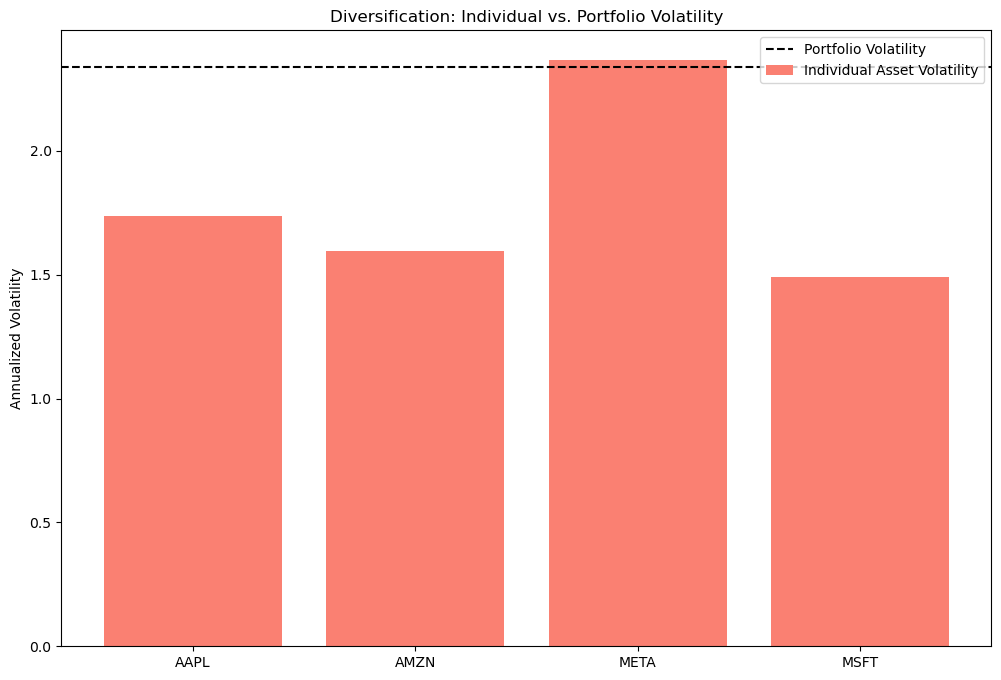

In [43]:
# Efficiency Ratios

eff_ratios = expected_returns/volat
portafolio_effciency = portfolio_return/portfolio_volatility

plt.figure(figsize=(12, 8))
plt.bar(df_data.columns, eff_ratios, color='salmon', label='Individual Asset Volatility')
plt.axhline(y=portafolio_effciency, color='black', linestyle='--', label='Portfolio Volatility')
plt.ylabel('Annualized Volatility')
plt.title('Diversification: Individual vs. Portfolio Volatility')
plt.legend()
plt.show()